In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
points = [(0,0),(0,0.25),(0.1,0.8),(0.2,0.9),(0.3,0.93),(0.45,0.00),(0.55,0.1),(0.7,-0.75),(0.8,-0.3),(0.9,-0.5),(1,0.2)]

In [43]:
xs = [x[0] for x in points]
ys = [y[1] for y in points]

# Our data. We will perform Bayesian curve fitting on it.

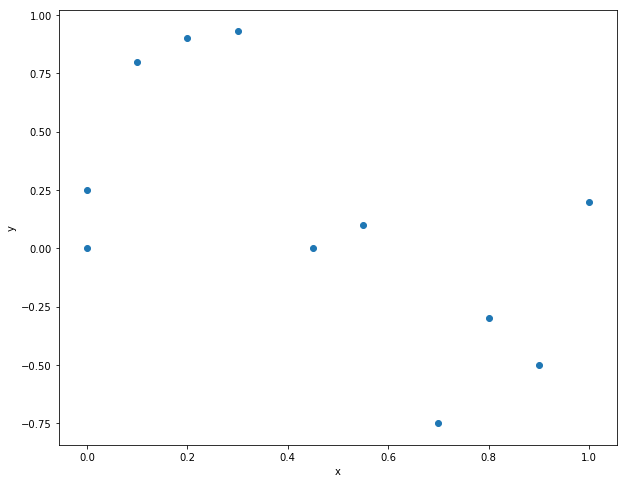

In [83]:
f = plt.figure(figsize=(10,8))
ax = f.add_subplot(111)
ax.scatter(xs,ys)

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

This is a demonstration on how to obtain the quantity $p(t|x,\mathbf{x},\mathbf{t})$, which will give us uncertainty about the new target $t$, **given**: the input that generated it $x$ and all the inputs along with corresponding targets: $\mathbf{x},\mathbf{t}$ respecitvely.

The equation is this:

$$p(t|x,\mathbf{x},\mathbf{t}) = \int  p(t|x,\mathbf{w}) p(\mathbf{w}|\mathbf{x},\mathbf{t}) d\mathbf{w}$$

for the derivation of the above go to my blog post on: smallmargin.uk

This equation has an analytic solution:
$$p(t|x,\mathbf{x},\mathbf{t}) = \mathcal{N}(t|m(x),s^2(x))$$

where:
$$m(x) = \beta \phi(x)^T \mathbf{S} \sum_{n=1}^N \phi(x_n) t_n$$
$$s^2(x) = \beta^{-1} + \phi(x)^T \mathbf{S} \phi(x)$$
matrix $\mathbf{S}$ is given by:
$$\mathbf{S}^{-1} = \alpha \mathbf{I} + \beta \sum_{n=1}^N \phi(x_n) \phi(x_n)^T$$
and $\phi(x)$ is defined such as: $\phi_i (x) = x^i$ for $i=0,...,M$

Method implemented below, correspond to these quantities/constructs.

Also note that $m(x) \in \mathbb{R}$, $s^2(x) \in \mathbb{R}$ and $\mathbf{S} \in \mathbb{R}^{(M+1)\times (M+1)}$

In [69]:
def variance(alpha, beta, new_x, x_vec, D):
    assert isinstance(alpha, float), "Alpha has to be a float."
    assert isinstance(beta, float),  "Beta has to be a float."
    assert isinstance(new_x, float), "New_x has to be a float."
    assert x_vec.shape[1] == 1,      "x_vec has to be a column vector."
    assert isinstance(D, int),       "Dimensions has to be an integer."

    S = matrix_S(alpha,beta,x_vec, D)
    return (1/beta)+(phi(new_x, D).T.dot(S).dot(phi(new_x, D)))[0][0]

def phi(x, D):
    """
    x - is the real valued constant.
    D - is an integer dimension.
    """
    assert isinstance(x, float), "x should be a float."
    assert isinstance(D, int), "Dimension D, should be an integer."

    dimension = D + 1  # We are including a constant here.
    returnVector = [0] * dimension
    for i in range(dimension): returnVector[i] += x ** i

    returnVector = np.array(returnVector)
    returnVector = returnVector.reshape(returnVector.shape + (1,))

    return returnVector

def mean(alpha, beta, new_x, target_vec, x_vec, D):
    assert isinstance(alpha, float), "Alpha should be a float."
    assert isinstance(beta, float),  "Beta should be a float."
    assert isinstance(new_x, float), "new_x should be a float: {}.".format(new_x)
    assert target_vec.shape[1] == 1, "target_vec should be a column vector, shape: {}.".format(target_vec.shape)
    assert x_vec.shape[1] == 1,      "x_vec should be a column vector."
    assert isinstance(D, int),       "Dimension should be an integer."
    assert len(target_vec)==len(x_vec), "x_vec and target_vec must be of the same dimensionality."
    
    sum_vec_x = 0
    for i in range(len(x_vec)): sum_vec_x += phi(x_vec[i][0], D) * target_vec[i][0]

    S = matrix_S(alpha, beta, x_vec, D)

    return beta * ((phi(new_x, D).T.dot(S)).dot(sum_vec_x))[0][0]

def matrix_S(alpha, beta, x_vec, D):

    assert isinstance(alpha, float), "Alpha is not a float."
    assert isinstance(beta, float),  "Beta is not a float."
    assert isinstance(D, int),       "Dimension is not an int."
    assert x_vec.shape[1] == 1, "x_vec must be a column vector."

    first_expr  = alpha*np.eye(D+1)
    second_expr = 0
    for i in range(len(x_vec)): second_expr += phi(x_vec[i][0], D).dot(phi(x_vec[i][0],D).T)
    return np.linalg.inv(first_expr+beta*second_expr)

To multiply column vecotr by row vector:
$$\phi(x_n) \phi(x)^T$$
we can write: np.outer(phi(2,2),phi(2,2)), which will return a $3 \times 3$ matrix (because we take into account the cosntant in $\mathbf{w}$ as well.

In [224]:
a = phi(2,2)

In [228]:
a.dot(a.T)

array([[ 1,  2,  4],
       [ 2,  4,  8],
       [ 4,  8, 16]])

Identity matrix can be created with np.eye(n)

In [82]:
2*np.eye(3)

array([[ 2.,  0.,  0.],
       [ 0.,  2.,  0.],
       [ 0.,  0.,  2.]])

To multiply row vector, $a = [1,2,3]$ by matrix $I = [[1,0,0],[0,1,0],[0,0,1]]$:

In [92]:
a = np.array([1,2,3])
I = np.eye(len(a))

np.dot(a,I)

array([ 1.,  2.,  3.])

# Actual procedural updating of the distribution of new target $t$

With start with just one given point: (0,0), which constitutes our vector x: $\mathbf{x}$. The new point then arrives, which is $(0,0.25)$. And we compute the $p(t|x,\mathbf{x},\mathbf{t})$ for this new point.

In [132]:
alpha = 5*10**(-3)
beta = 11.1
M = 9

In [133]:
x_vec = np.linspace(-5,0,200)
x_vec = x_vec.reshape(x_vec.shape + (1,))
t_vec = np.array([np.sin(x+np.random.normal(0,np.sqrt(1/beta))) for x in x_vec])
t_vec = t_vec.reshape(t_vec.shape + (1,))

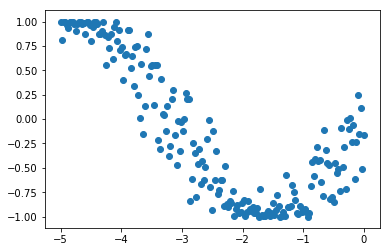

In [134]:
plt.scatter(x_vec,t_vec)
plt.show()

In [135]:
x_predict = np.array(np.linspace(0.,5.,200))
x_predict = x_predict.reshape(x_predict.shape + (1,))
y_predict = np.array([np.sin(x+np.random.normal(0,np.sqrt(1/beta))) for x in x_predict])
y_predict = y_predict.reshape(y_predict.shape + (1,))

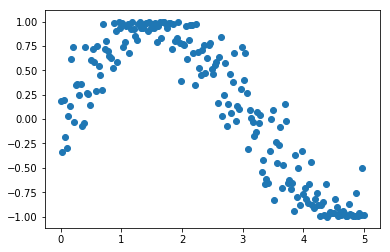

In [136]:
plt.scatter(x_predict,y_predict)
plt.show()

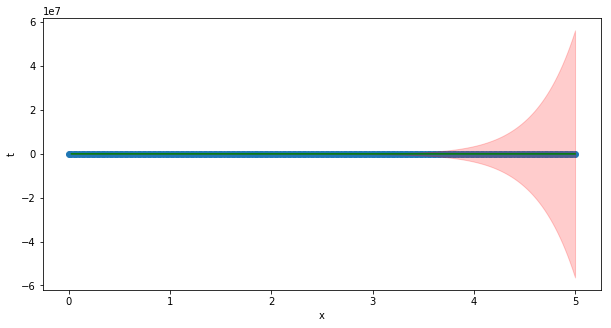

In [138]:
means     = [0.] * (len(x_predict) - 1)  # Important, have 0., otherwise will be an array of integers.
variances = [0.] * (len(x_predict) - 1)

for i in range(len(x_predict) - 1):
#     x_vec = np.append(x_vec,x_predict[i]) # x_vec
#     x_vec = x_vec.reshape(x_vec.shape + (1,))
#     t_vec = np.append(t_vec,y_predict[i]) # target_vec
#     t_vec = t_vec.reshape(t_vec.shape + (1,))
    new_datapoint = x_predict[i + 1]
    new_x = new_datapoint[0]
    p_t_mean = mean(  alpha,  beta, new_x, t_vec, x_vec, M)
    p_t_var = variance(alpha, beta, new_x, x_vec, M)
    means[i] = p_t_mean
    variances[i] = (0.01*p_t_var + means[i], means[i] - 0.01*p_t_var)

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)

ax.scatter(x_predict,y_predict)
ax.plot(x_predict[1:],means,c='green')
miny = [y[1] for y in variances]
maxy = [y[0] for y in variances]
ax.fill_between(x_predict[1:].T[0],miny,maxy,alpha=0.2,color='red')

ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()

In [139]:
means

[-0.086903661263568202,
 -0.070416671637622122,
 -0.05453972793079629,
 -0.039381524958662338,
 -0.025063413533098353,
 -0.011720509435963321,
 0.0004971286102772865,
 0.011423257234673656,
 0.020874133008510397,
 0.028647128175362014,
 0.034519260459273934,
 0.038245669034222371,
 0.0395579691772582,
 0.038162573223235081,
 0.033738874323171332,
 0.025937395393702899,
 0.01437777561150142,
 -0.0013532653829315677,
 -0.021704107847472186,
 -0.047160509458626619,
 -0.078247959395230285,
 -0.11553418304538354,
 -0.15963174241769593,
 -0.21120071731565984,
 -0.27095154448470565,
 -0.33964799793320705,
 -0.41811025405477265,
 -0.507218015223043,
 -0.60791405820054933,
 -0.72120747790904716,
 -0.84817737119738013,
 -0.9899768016650341,
 -1.1478363997593988,
 -1.3230686690658331,
 -1.5170719844056293,
 -1.7313353213248774,
 -1.9674423943972215,
 -2.2270767892361616,
 -2.5120265575940719,
 -2.8241892014164476,
 -3.1655775420600549,
 -3.5383244743337854,
 -3.9446887840284033,
 -4.3870614138431